# Time series forecasting with Prophet

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
path = "../../../data/statsmodels/AirPassengers.parquet"

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ['values']

series = df['values']
series

1949-01-31    112
1949-02-28    118
             ... 
1960-11-30    390
1960-12-31    432
Freq: ME, Name: values, Length: 144, dtype: int64

## Prepare DataFrame for Prophet

In [4]:
df = pd.DataFrame({
    'ds': series.index,
    'y': series.values,
}, index=series.index)

df

,ds,y
1949-01-31,1949-01-31,112
1949-02-28,1949-02-28,118
...,...,...
1960-11-30,1960-11-30,390
1960-12-31,1960-12-31,432


## Model fit

In [5]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

holidays = make_holidays_df(country='US', year_list=list(range(1960, 2020)))

model = Prophet(
    yearly_seasonality=True,
    holidays=holidays,
    seasonality_mode='multiplicative'  # or 'additive'
)

model.fit(df)

11:31:04 - cmdstanpy - INFO - Chain [1] start processing
11:31:04 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
model.params

OrderedDict([('lp__', array([[504.326]])),
             ('k', array([[0.393833]])),
             ('m', array([[0.184949]])),
             ('delta',
              array([[ 5.94136e-09,  6.24471e-09,  4.92288e-04,  9.15040e-02,
                       1.75554e-04,  2.83096e-09,  1.53451e-08,  1.68292e-08,
                      -1.14049e-09, -6.58009e-09, -7.57653e-09,  9.93564e-09,
                       1.12797e-08,  1.48152e-01,  1.36888e-01,  1.75862e-08,
                       1.51163e-09, -2.29739e-08, -4.10181e-04, -6.51883e-02,
                      -6.28361e-02, -5.42087e-02, -9.05613e-09,  8.16967e-09,
                       2.27650e-01]])),
             ('sigma_obs', array([[0.0164471]])),
             ('beta',
              array([[-0.0624946 , -0.155422  ,  0.0975794 ,  0.0355634 , -0.0702496 ,
                      -0.00186643, -0.042387  , -0.0217824 , -0.00592623,  0.0919416 ,
                       0.12103   ,  0.0320689 ,  0.0171235 , -0.0926655 , -0.0699837 ,
           

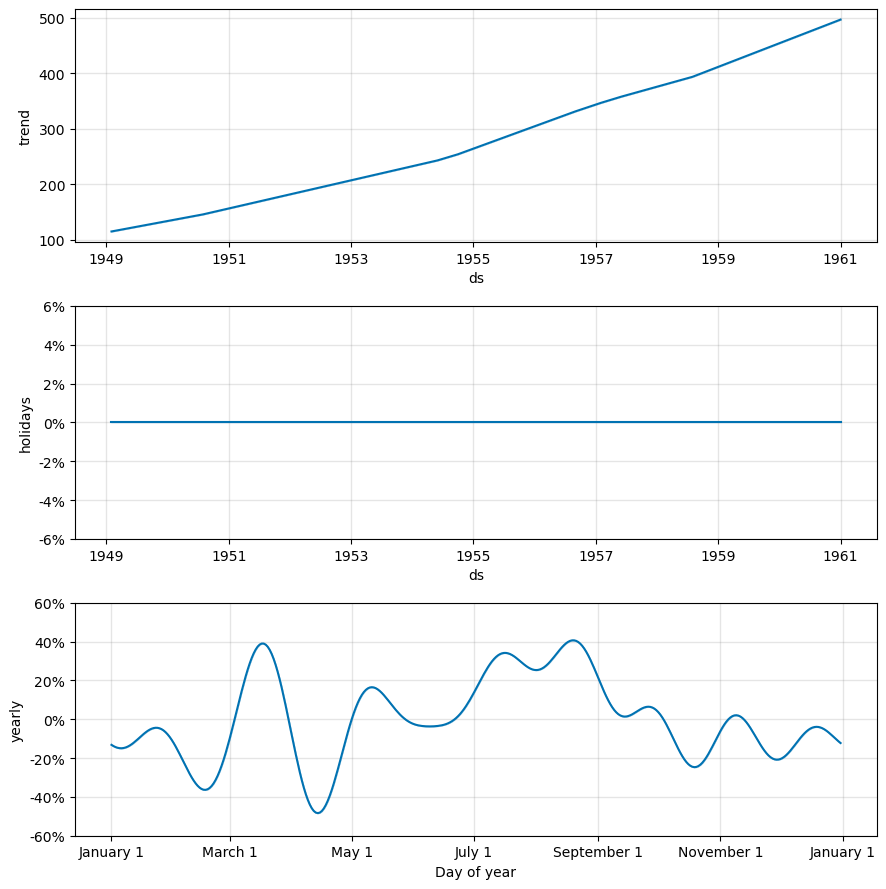

In [7]:
forecast = model.predict(df)
model.plot_components(forecast);

## Forecast

In [8]:
future = model.make_future_dataframe(periods=48, freq='ME')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,1964-08-31,804.322300,780.475299,829.280933
188,1964-09-30,685.596010,663.209125,707.464061
...,...,...,...,...
190,1964-11-30,525.884549,506.168041,544.393189
191,1964-12-31,583.970836,561.965220,605.506596


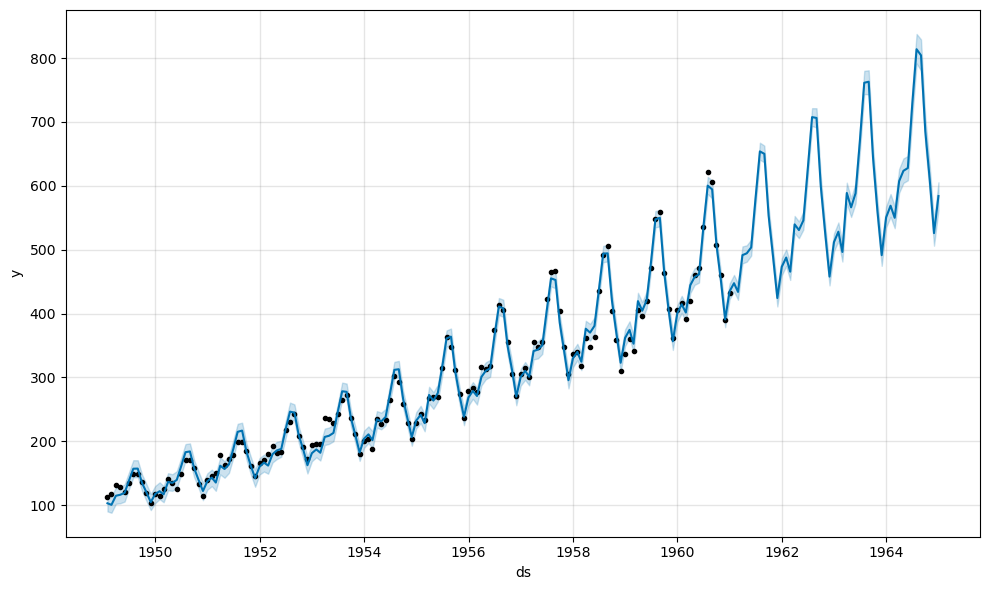

In [9]:
model.plot(forecast);

In [10]:
utils.plot_prophet_forecast(df['y'], forecast)

## Configuration

1. Prophet automatically detects trend and seasonality using changepoints.
2. You configure:

   * **Trend flexibility** (with or without change points)
   * **Additive vs. multiplicative** seasonality (`seasonality_mode`)
   * **Custom seasonalities** (optional)
   * **Holiday effects** (optional)


**📌 Rule of Thumb**

> “Prophet config is semi-automatic: trend and seasonal components are learned with flexible change points. You choose seasonal mode and horizon — minimal tuning required.”



**Seasonal decomposition visual insight only.**

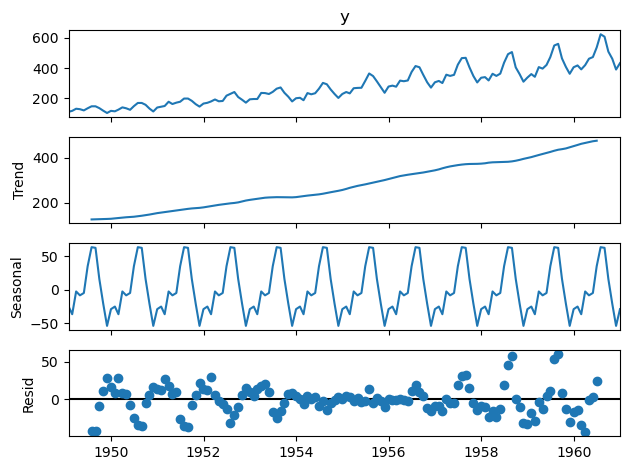

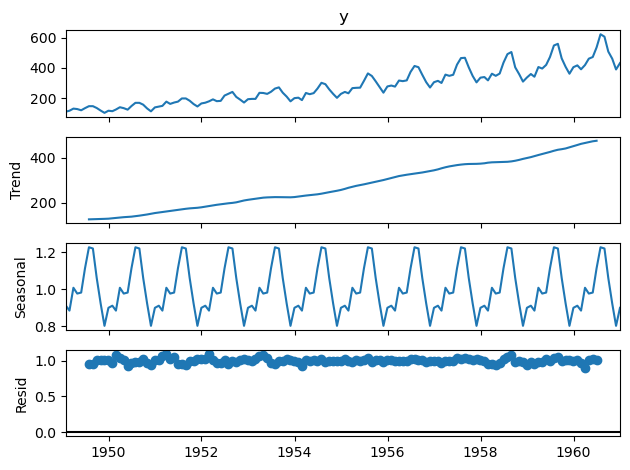

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['y'], model="additive", period=12).plot();
seasonal_decompose(df['y'], model="multiplicative", period=12).plot();

## Variation playground

### Prophet

In [12]:
from modules import utils

df = series.to_frame()

df = utils.get_model_forecast_prophet(df, column="values", mode="additive")
df = utils.get_model_forecast_prophet(df, column="values", mode="multiplicative")

df

11:03:05 - cmdstanpy - INFO - Chain [1] start processing
11:03:05 - cmdstanpy - INFO - Chain [1] done processing
11:03:05 - cmdstanpy - INFO - Chain [1] start processing
11:03:05 - cmdstanpy - INFO - Chain [1] done processing


,values,prophet_additive,prophet_multiplicative
1949-01-31,112.0,NaN,NaN
1949-02-28,118.0,NaN,NaN
...,...,...,...
1964-11-30,NaN,568.963094,525.884549
1964-12-31,NaN,597.874859,583.970836


In [13]:
df.plot()

### SARIMA vs Exponential Smoothing vs Prophet

In [14]:
import numpy as np

df = series.to_frame()
df["values_log"] = np.log(df["values"])

df_forecast = utils.get_model_forecast(
    df, "values_log", order=(12, 1, 1), horizon=96, forecast_exp=True
)
df_forecast = utils.get_model_forecast(
    df_forecast,
    "values_log",
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    horizon=96,
    forecast_exp=True,
)
df_forecast = utils.get_model_forecast_exponential_smoothing(
    df_forecast,
    "values",
    horizon=96,
    class_config={"trend": "add", "seasonal": "mul", "seasonal_periods": 12},
)
df_forecast = utils.get_model_forecast_prophet(
    df_forecast, "values", mode="multiplicative", horizon=96
)

df_forecast = df_forecast.drop(columns=["values_log"])
df_forecast.plot(color="variable")

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

11:03:05 - cmdstanpy - INFO - Chain [1] start processing
11:03:05 - cmdstanpy - INFO - Chain [1] done processing


## Diagnostics and assumptions

Although Prophet is robust and doesn’t require stationarity or normal residuals, residual analysis helps confirm quality.

### Residual calculation

In [15]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=holidays,
    seasonality_mode="multiplicative",
)

df = pd.DataFrame({
    'ds': series.index,
    'y': series.values
})

model.fit(df)

forecast = model.predict(df)

df_forecast = forecast.set_index("ds")[["yhat"]].join(df.set_index("ds"))
df_forecast["residuals"] = df_forecast["y"] - df_forecast["yhat"]

residuals = df_forecast["residuals"].dropna()
residuals

11:03:06 - cmdstanpy - INFO - Chain [1] start processing
11:03:06 - cmdstanpy - INFO - Chain [1] done processing


ds
1949-01-31     9.102743
1949-02-28    17.532820
                ...    
1960-11-30    -0.823304
1960-12-31    -2.804351
Name: residuals, Length: 144, dtype: float64

### Autocorrelation

#### Plot

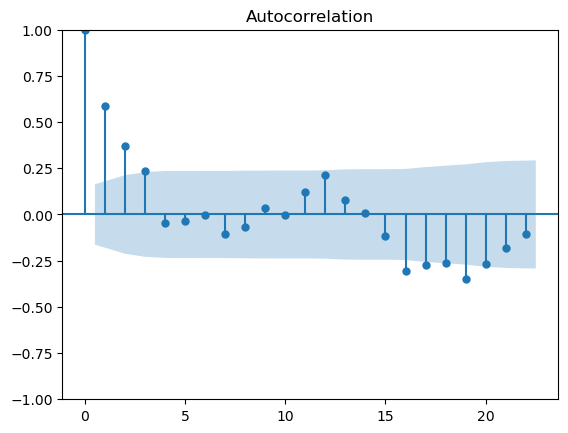

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

#### Test: Ljung-Box

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,82.668229,0.000000
20,167.529442,0.000000
30,219.288026,0.000000


### Normality

#### Plot

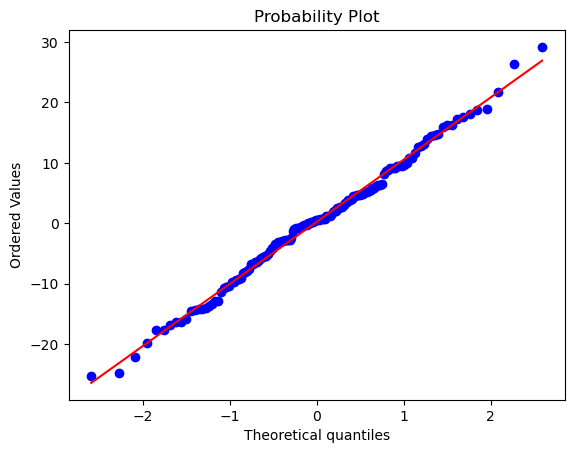

In [18]:
from scipy import stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

#### Test: Jarque-Bera

In [19]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(0.018871983201470002), pvalue=np.float64(0.9906083876708386))

### Homoscedasticity

#### Plot

In [20]:
residuals.plot()

#### Test

In [21]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(16.596914206299374),
 np.float64(0.08377279981299146),
 1.7388132803953582,
 0.0793106680683477)